['dear', 'did', 'my', 'you', 'friend', 'it', 'is', 'know', 'my', 'friends', 'that', 'that', 'is', 'more', 'i', 'house', 'go', 'to', 'bigger', 'her', 'see', 'house', 'in', 'you', 'than', 'later', 'england', 'at', 'sunday', 'my', 'house', 'best', 'ken', 'gwon']
dear did my you friend it is know my friends that that is more i house go to bigger her see house in you than later england at sunday my house best ken gwon


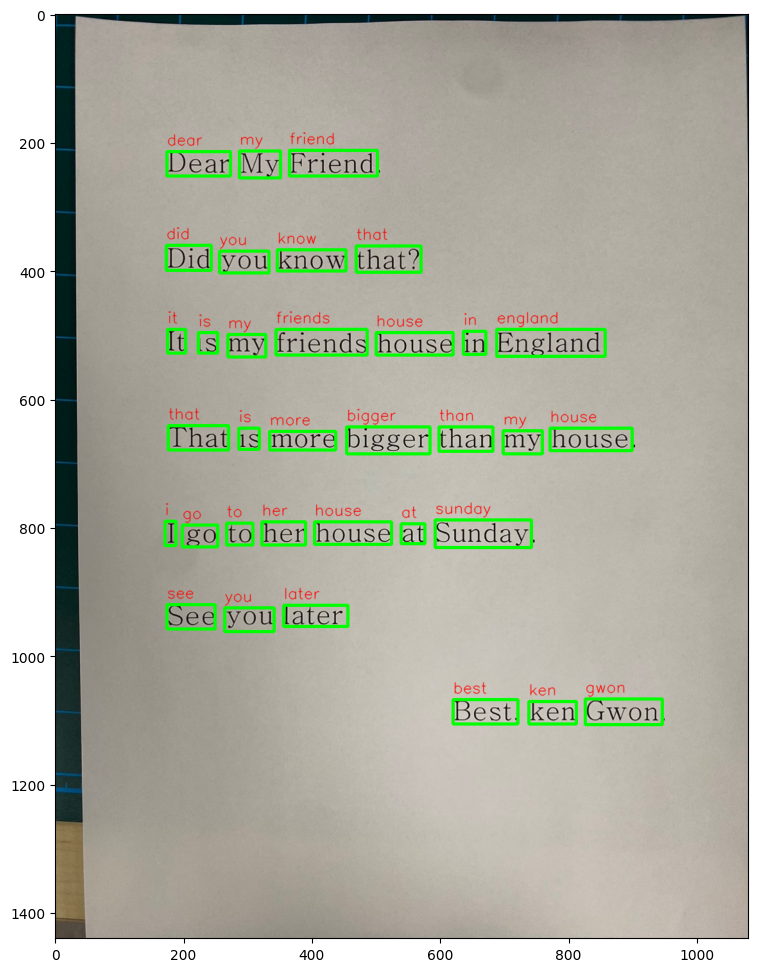

In [1]:
from pathlib import Path
import PyQt5
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image
from notebook_utils import load_image


def multiply_by_ratio(ratio_x, ratio_y, box):
    return [
        max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x
        for idx, shape in enumerate(box[:-1])
    ]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.2, conf_labels=True):
    # RGB값의 코드 가독성을 높이기 위한 dictionary 선언
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # resize 비율 계산
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # 이미지를 출력하기 위한 바탕 이미지 변수 선언
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    for box, annotation in boxes:
        conf = box[-1] # confidence값은 모델 output의 마지막 요소값이다.

        if conf > threshold:             
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3) 

            if conf_labels: 
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image



# 모델 준비
model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-resnet-fc"
detection_model_path = (model_dir / "intel/horizontal-text-detection-0001" / precision / detection_model).with_suffix(".xml")
recognition_model_path = (model_dir / "public/text-recognition-resnet-fc" / precision / recognition_model).with_suffix(".xml")

# 텍스트 detection 모델 생성
core = ov.Core()
detection_model = core.read_model(model=detection_model_path, weights=detection_model_path.with_suffix(".bin"))
detection_compiled_model = core.compile_model(model=detection_model, device_name='AUTO')

# 텍스트 detection 모델의 input shape에 맞게 이미지 transform 준비
detection_input_layer = detection_compiled_model.input(0)
N, C, H, W = detection_input_layer.shape
image = cv2.imread("sample_letter.jpg")
resized_image = cv2.resize(image, (W, H))
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# 텍스트 detection 모델 추론
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]
boxes = boxes[~np.all(boxes == 0, axis=1)] # 내용이 0뿐인 박스는 제거


# 텍스트 recognition 모델 생성
recognition_model = core.read_model(model=recognition_model_path, weights=recognition_model_path.with_suffix(".bin"))
recognition_compiled_model = core.compile_model(model=recognition_model, device_name='AUTO')

# 텍스트 recognition 모델의 input shape에 맞게 이미지 transform 준비
recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)
_, _, H, W = recognition_input_layer.shape


grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# "text-recognition-resnet-fc" 모델이 제공하는 encode output 문자열은 다음과 같음(나머지 문자열은 지원하지 않음)
letters = "~0123456789abcdefghijklmnopqrstuvwxyz"

annotations = list()
cropped_images = list()

for i, crop in enumerate(boxes):
    # Get coordinates on corners of a crop.
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with the recognition model.
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze the output to remove unnecessary dimension.
    recognition_results_test = np.squeeze(result)

    # Read an annotation based on probabilities from the output layer.
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from `argmax` signalizes an end of a string.
        if parsed_letter == letters[0]:
            break
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))



plt.figure(figsize=(12, 12))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True))

# cv2.imshow("result", convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True))


ocr_text_result = [
    annotation
    for _, annotation in sorted(zip(boxes, annotations), key=lambda x: x[0][0] ** 2 + x[0][1] ** 2)
]
print(ocr_text_result)


result_string = ' '.join(ocr_text_result)
print(result_string)






In [7]:
## imoprt
from transformers import pipeline, AutoTokenizer
from optimum.intel.openvino import OVModelForSeq2SeqLM, OVModelForSequenceClassification
import re
import transformers
from tqdm.notebook import tqdm

## Grammar Checker
grammar_checker_model_id = "textattack/roberta-base-CoLA"
grammar_checker_dir = Path("roberta-base-cola")
grammar_checker_tokenizer = AutoTokenizer.from_pretrained(grammar_checker_model_id)


if grammar_checker_dir.exists():
    grammar_checker_model = OVModelForSequenceClassification.from_pretrained(grammar_checker_dir, device='AUTO')
else:
    grammar_checker_model = OVModelForSequenceClassification.from_pretrained(grammar_checker_model_id, export=True, device='AUTO')
    grammar_checker_model.save_pretrained(grammar_checker_dir)


input_text = "They are moved by salar energy"
grammar_checker_pipe = pipeline("text-classification", model=grammar_checker_model, tokenizer=grammar_checker_tokenizer)
# result = grammar_checker_pipe(input_text)[0]
# example
# print(f"input text: {input_text}")
# print(f'predicted label: {"contains_errors" if result["label"] == "LABEL_1" else "no errors"}')
# print(f'predicted score: {result["score"] :.2}')


## Grammar Corrector
grammar_corrector_model_id = "pszemraj/flan-t5-large-grammar-synthesis"
grammar_corrector_dir = Path("flan-t5-large-grammar-synthesis")
grammar_corrector_tokenizer = AutoTokenizer.from_pretrained(grammar_corrector_model_id)


if grammar_corrector_dir.exists():
    grammar_corrector_model = OVModelForSeq2SeqLM.from_pretrained(grammar_corrector_dir, device=device.value)
else:
    grammar_corrector_model = OVModelForSeq2SeqLM.from_pretrained(grammar_corrector_model_id, export=True, device=device.value)
    grammar_corrector_model.save_pretrained(grammar_corrector_dir)
grammar_corrector_pipe = pipeline("text2text-generation", model=grammar_corrector_model, tokenizer=grammar_corrector_tokenizer)
# result = grammar_corrector_pipe(input_text)[0]
# example
# print(f"input text:     {input_text}") 
# print(f'generated text: {result["generated_text"]}') 


## Prepare Demo Pipeline
def split_text(text: str) -> list:
    """
    Split a string of text into a list of sentence batches.

    Parameters:
    text (str): The text to be split into sentence batches.

    Returns:
    list: A list of sentence batches. Each sentence batch is a list of sentences.
    """
    # Split the text into sentences using regex
    sentences = re.split(r"(?<=[^A-Z].[.?]) +(?=[A-Z])", text)

    # Initialize a list to store the sentence batches
    sentence_batches = []

    # Initialize a temporary list to store the current batch of sentences
    temp_batch = []

    # Iterate through the sentences
    for sentence in sentences:
        # Add the sentence to the temporary batch
        temp_batch.append(sentence)

        # If the length of the temporary batch is between 2 and 3 sentences, or if it is the last batch, add it to the list of sentence batches
        if len(temp_batch) >= 2 and len(temp_batch) <= 3 or sentence == sentences[-1]:
            sentence_batches.append(temp_batch)
            temp_batch = []

    return sentence_batches


def correct_text(text: str, checker: transformers.pipelines.Pipeline, corrector: transformers.pipelines.Pipeline, separator: str = " ") -> str:
    """
    Correct the grammar in a string of text using a text-classification and text-generation pipeline.

    Parameters:
    text (str): The inpur text to be corrected.
    checker (transformers.pipelines.Pipeline): The text-classification pipeline to use for checking the grammar quality of the text.
    corrector (transformers.pipelines.Pipeline): The text-generation pipeline to use for correcting the text.
    separator (str, optional): The separator to use when joining the corrected text into a single string. Default is a space character.

    Returns:
    str: The corrected text.
    """
    # Split the text into sentence batches
    sentence_batches = split_text(text)

    # Initialize a list to store the corrected text
    corrected_text = []

    # Iterate through the sentence batches
    for batch in tqdm(
        sentence_batches, total=len(sentence_batches), desc="correcting text.."
    ):
        # Join the sentences in the batch into a single string
        raw_text = " ".join(batch)

        # Check the grammar quality of the text using the text-classification pipeline
        results = checker(raw_text)

        # Only correct the text if the results of the text-classification are not LABEL_1 or are LABEL_1 with a score below 0.9
        if results[0]["label"] != "LABEL_1" or (
            results[0]["label"] == "LABEL_1" and results[0]["score"] < 0.9
        ):
            # Correct the text using the text-generation pipeline
            corrected_batch = corrector(raw_text)
            corrected_text.append(corrected_batch[0]["generated_text"])
        else:
            corrected_text.append(raw_text)

    # Join the corrected text into a single string
    corrected_text = separator.join(corrected_text)
    return corrected_text


#test_text = "dear my friend. did you know that? it is my friends house in england. that is more bigger than my house. i go to her house at sunday. see you later. best, ken gwon"
test_text = result_string

corrected_text = correct_text(test_text, grammar_checker_pipe, grammar_corrector_pipe)

print(f"input text: {test_text}\n")
print(f'generated text: {corrected_text}')

# 문자열 바뀐 부분 확인
# pip install diff_match_patch
from diff_match_patch import diff_match_patch

before = test_text
after = corrected_text
temp = "" 

dmp = diff_match_patch()
diff = dmp.diff_main(before, after)
dmp.diff_cleanupSemantic(diff)

for d in diff:
    if d[0] == 1:
        temp += ("[+\'"+d[1]+"\']")
    elif d[0] == 0:
        temp += (d[1])
    elif d[0] == -1:
        temp += ("[-\'"+d[1]+"\']")

print()
print("compare text: ", temp)

Compiling the model to AUTO ...
Setting OpenVINO CACHE_DIR to roberta-base-cola/model_cache
Compiling the encoder to AUTO ...
Compiling the decoder to AUTO ...
Compiling the decoder to AUTO ...


correcting text..:   0%|          | 0/1 [00:00<?, ?it/s]

input text: dear did my you friend it is know my friends that that is more i house go to bigger her see house in you than later england at sunday my house best ken gwon

generated text: Do you know my friend that it is more important to go to her house in London than to go to my house in Beijing on a Sunday?

compare text:  [-'dear did my you friend it is'][+'Do you'] know my friend[-'s'] that [-'tha'][+'i']t is more i[-' house go to bigger her see house in you than later england at sunday my house best ken gwon'][+'mportant to go to her house in London than to go to my house in Beijing on a Sunday?']
